In [1]:
from edc import check_compatibility
check_compatibility("user-2021.12", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_SECRET`, `SH_CLIENT_NAME`, `SH_INSTANCE_ID`, `SH_CLIENT_ID`


# EDC Sentinel Hub: Data Fusion

## Example 1: Filling clouds in a Sentinel-2 image with Sentinel-1 SAR data

This notebook shows how to request [S1 GRD](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-1-GRD) and [S2 L1A](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-2-L2A) from the [Sentinel Hub API](https://docs.sentinel-hub.com/api/latest/#/API/), and how to merge the data in an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/).

The S2 True Color composition is returned (R: B04, G: B03, B: B02), whereas cloud covered areas are replaced by the S1 VV polarization band.

### Prerequisites

This notebook requires an active subscription to:

-   EDC Sentinel Hub


In [2]:
# Request tools imports
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [3]:
# Utilities
import os
import shapely.geometry
import IPython.display

In [4]:
%matplotlib inline

### Setup

In [5]:
# Pass the Sentinel Hub Client ID and Secret to variables to be used in the request.
my_client_id = %env SH_CLIENT_ID
my_client_secret = %env SH_CLIENT_SECRET

In [6]:
# Create an OAuth2 session based on the client ID
client = BackendApplicationClient(client_id=my_client_id)
oauth = OAuth2Session(client=client)

The Sentinel Hub API uses OAuth2 Authentication and requires that you have an [access token](https://docs.sentinel-hub.com/api/latest/#/API/authentication). These tokens are limited in time, but a new one can be requested with the following command.

In [7]:
# Get a token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=my_client_id, client_secret=my_client_secret)

## Setting an area of interest

We will download Sentinel-1 and Sentinel-2  imagery of the hills located to the North of # Ljubljana, Slovenia.
The bounding box is in the WGS84 coordinate system, and consists of the longitude and latitude coordinates of lower left and upper right corners.

In [8]:
# Set bounding box coordinates for the area of interest
bbox = (14.37595, 46.09347, 14.56924, 46.19266)

In [9]:
# Display the coordinates on a map
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

## API request

We need to specify arguments to send a POST request, more information about all the availaible options [here](https://docs.sentinel-hub.com/api/latest/reference/#operation/process):

-   The access point URL:  set it to `https://services.sentinel-hub.com/api/v1/process`

-   `json` - the contents of the request containing:
	- `input`: (required) specifies the data to request:
		- `bounds`: defines the request bounds by specifying the bounding box and/or geometry for the request.
		- `data`: describes the data being requested along with certain processing and filtering parameters.
	- `output`: (optional) allows to set parameters for the returned data
		-  `width`: The request image width. Must be an integer between 1 and 2500. 
        -  `height`: The request image height. Must be an integer between 1 and 2500. 
	- `evalscript`: calculates the output values for each pixel


#### Step 1
First, set the input options. The options are set in the form of a dictionary with key/values pairs.

1. Specify the bounds of your request using the bounding box previously described and specifying the [projection]( 
https://docs.sentinel-hub.com/api/latest/#/API/crs?id=crs-support) (one of the CRS supported by Sentinel Hub API).

2. Specify the data to fetch. As in this example there are 2 data sources (Sentinel-1 and Sentinel-2), the options for each sensor are specified in a list of dictionaries.  

In [10]:
# 1. Bounds 
bounds = {"properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}, "bbox": bbox}

# 2. Data
data = [{"id": "s1", 
         "type": "S1GRD",
          "dataFilter": {"timeRange": {"from": "2020-02-01T00:00:00Z",
                                       "to": "2020-02-06T00:00:00Z"},
                         "mosaickingOrder": "mostRecent"}},
         {"id": "l2a",
          "type": "S2L2A",
          "dataFilter": {"timeRange": {"from": "2020-02-01T00:00:00Z",
                                       "to": "2020-02-06T00:00:00Z"},
                         "mosaickingOrder": "mostRecent"}}]
# Set the options to the input
input_options = {"bounds": bounds, "data": data,}

#### Step 2

Then set the output options. The default output size of the requested image is 256x256 pixels, so here we will modify the output to be larger. The result will be displayed only, therefore we also set the output format to jpeg.

In [11]:
output_options = {"width": 640, "height": 640, "responses": [{"format": {"type": "image/jpeg",
                                                                         "quality": 90}}]}

#### Step 3

The [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/) is a piece of javascript code that allows to process the pixels of the images that are returned.

In the current example, the S1 and S2 bands needed are called in the `setup` function of the script. 

The `evaluatePixel` function returns the S1 VV polarization band for the pixels in the S2-L2A SCL band (see [here](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-2-L2A)) classified as:

-  7 - Clouds low probability / Unclassified
-  8 - Clouds medium probability
-  9 - Clouds high probability
-  10 - Cirrus 

For all the other pixels the S2 [True Color](https://www.sentinel-hub.com/eoproducts/true-color) visualisation is returned (scaled by 2.5 for better viewing). 

In [12]:
evascript = """
//VERSION=3
function setup (){
  return {
    input: [
      {datasource: "s1", bands:["VV"]},
      {datasource: "l2a", bands:["B02", "B03", "B04", "SCL"], units:["REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "DN"]}],
    output: [
      {id: "default", bands: 3, sampleType: SampleType.AUTO}
    ]
  }
}
function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
  var sample = samples.s1[0]
  var sample2 = samples.l2a[0]
  
  if ([7, 8, 9, 10].includes(sample2.SCL)) {
    return {
      default: [sample.VV, sample.VV, sample.VV]
    }
  } else {
    return {
      default: [sample2.B04*2.5, sample2.B03*2.5, sample2.B02*2.5]
    }
  }
}
"""

#### Step 4 (final)

The different parts of the request built above are merged together in the `oauth.post` command and the request is posted. If all the elements are correct, the command should return a `200` status.

In [13]:
response = oauth.post('https://services.sentinel-hub.com/api/v1/process',
  json={"input": input_options,
        "evalscript": evascript,
        "output": output_options,
})

print("Request status: %s, %s" % (response.status_code, response.reason))

Request status: 200, OK


If the request was successful, you can now observe the image:

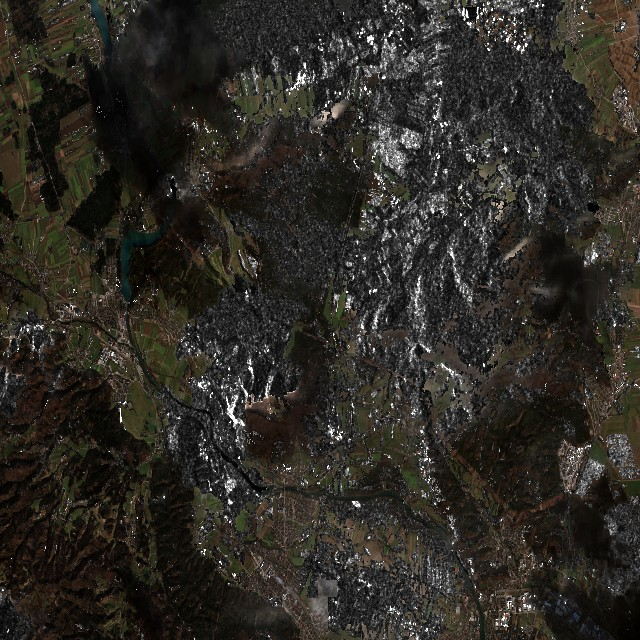

In [14]:
IPython.display.Image(response.content)